## Import Library

In [1]:
# file: xgboost_ks.ipynb
# # %pip install mlflow
# %pip install xgboost

## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


In [3]:
def prepare_weekly_city(df_raw, city_name):
    df_city = df_raw[df_raw["City"] == city_name].copy()
    df_city["Date"] = pd.to_datetime(df_city["Date"])
    df_city = df_city.set_index("Date").sort_index()

    agg_dict = {
        "Cases": "sum",
        "Precip": "sum",
        "Pressure": "mean",
        "Tmean": "mean",
        "Tmin": "mean",
        "Tmax": "mean",
        "Humidity": "mean",
        "Windspeed": "mean",
        "BI": "mean",
        "HI": "mean",
        "CI": "mean",
        "PopDensity_km2": "mean",
    }

    # 1) Weekly aggregation with regular weekly index
    df_weekly = df_city.resample("W").agg(agg_dict).asfreq("W")

    # 2) Handle cases (if any NaN after resample, treat as 0)
    df_weekly["Cases"] = df_weekly["Cases"].fillna(0)

    # 3) Weather interpolation
    weather_cols = ["Precip", "Pressure", "Tmean", "Tmin", "Tmax",
                    "Humidity", "Windspeed"]
    df_weekly[weather_cols] = (
        df_weekly[weather_cols]
        .interpolate(method="time")
        .ffill()
        .bfill()
    )

    # 4) Mosquito indices: carry-forward then backward
    index_cols = ["BI", "HI", "CI"]
    df_weekly[index_cols] = df_weekly[index_cols].ffill().bfill()

    return df_weekly

## Load daily data & filter Kaohsiung

In [4]:
# Load merged daily dataset
df_raw = pd.read_csv("../data/3_df_merged_cleaned.csv")


df_ks = prepare_weekly_city(df_raw, "Kaohsiung City")


## Aggregate to weekly data

In [5]:
agg_dict = {
    "Cases": "sum",        # weekly total cases
    "Precip": "sum",       # weekly total rain

    "Pressure": "mean",
    "Tmean": "mean",
    "Tmin": "mean",
    "Tmax": "mean",
    "Humidity": "mean",
    "Windspeed": "mean",

    "BI": "mean",
    "HI": "mean",
    "CI": "mean",

    "PopDensity_km2": "mean"  # constant, but mean is fine
}

df_ks_weekly = df_ks.resample("W").agg(agg_dict)

df_ks_weekly.info()
df_ks_weekly.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 784 entries, 2010-01-03 to 2025-01-05
Freq: W-SUN
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cases           784 non-null    float64
 1   Precip          784 non-null    float64
 2   Pressure        784 non-null    float64
 3   Tmean           784 non-null    float64
 4   Tmin            784 non-null    float64
 5   Tmax            784 non-null    float64
 6   Humidity        784 non-null    float64
 7   Windspeed       784 non-null    float64
 8   BI              784 non-null    float64
 9   HI              784 non-null    float64
 10  CI              784 non-null    float64
 11  PopDensity_km2  784 non-null    float64
dtypes: float64(12)
memory usage: 79.6 KB


,Cases,Precip,Pressure,Tmean,Tmin,Tmax,Humidity,Windspeed,BI,HI,CI,PopDensity_km2
Date,,,,,,,,,,,,
2010-01-03,11.0,0.38,1015.350000,19.886667,16.400000,23.666667,73.273333,2.266667,1.666500,1.666500,2.857000,941.037509
2010-01-10,10.0,0.25,1016.337143,19.134286,15.857143,23.471429,73.708571,2.201429,2.266428,1.712733,2.196624,941.037509
2010-01-17,6.0,0.09,1021.761429,17.460000,13.357143,21.971429,67.430000,1.958571,1.564114,1.374100,2.580969,941.037509
2010-01-24,6.0,0.00,1019.902857,21.257143,17.757143,25.285714,70.812857,1.644286,1.017286,0.922613,1.312707,941.037509
2010-01-31,4.0,0.11,1017.801429,21.922857,18.485714,25.942857,73.111429,1.825714,1.069172,1.004289,1.503589,941.037509


## Add lag features

In [6]:
lags = [1, 2, 4, 8, 10, 11, 12, 15]


In [7]:
def add_lag_features(df, lag_cols, lags):
    """
    df: DataFrame with Date index (weekly)
    lag_cols: list of column names to lag
    lags: list of integers, lag in weeks
    
    Returns: new DataFrame with added lag columns
    """
    df = df.copy()
    for col in lag_cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


In [8]:
lag_cols = ["Cases", "Tmean", "Tmin", "Tmax",
            "BI", "HI", "CI",
            "Precip", "Humidity"]

lags = [1, 2, 4, 8, 10, 11, 12, 15]

df_lagged = add_lag_features(df_ks_weekly, lag_cols, lags)

# Drop initial rows where lagged values are NaN
df_lagged = df_lagged.dropna().copy()

df_lagged.head()
#


,Cases,Precip,Pressure,Tmean,Tmin,Tmax,Humidity,Windspeed,BI,HI,...,Precip_lag12,Precip_lag15,Humidity_lag1,Humidity_lag2,Humidity_lag4,Humidity_lag8,Humidity_lag10,Humidity_lag11,Humidity_lag12,Humidity_lag15
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-18,3.0,0.23,1015.147143,24.632857,20.828571,28.500000,70.982857,2.338571,1.885280,1.672632,...,0.00,0.38,73.235714,68.222857,72.720000,74.938571,72.808571,73.111429,70.812857,73.273333
2010-04-25,1.0,1.38,1013.008571,25.987143,23.057143,29.057143,76.360000,1.961429,1.312312,1.224984,...,0.11,0.25,70.982857,73.235714,69.988571,72.545714,75.444286,72.808571,73.111429,73.708571
2010-05-02,0.0,1.27,1014.151429,24.998571,22.300000,27.842857,73.317143,1.964286,1.784477,1.325117,...,0.00,0.09,76.360000,70.982857,68.222857,73.155714,74.938571,75.444286,72.808571,67.430000
2010-05-09,3.0,0.12,1008.391429,27.788571,25.600000,30.700000,75.341429,2.060000,1.886293,1.438994,...,0.24,0.00,73.317143,76.360000,73.235714,63.764286,72.545714,74.938571,75.444286,70.812857
2010-05-16,0.0,0.46,1009.537143,28.344286,26.000000,30.914286,69.212857,2.430000,3.137796,2.553839,...,2.74,0.11,75.341429,73.317143,70.982857,72.720000,73.155714,72.545714,74.938571,73.111429


In [9]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 769 entries, 2010-04-18 to 2025-01-05
Freq: W-SUN
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cases           769 non-null    float64
 1   Precip          769 non-null    float64
 2   Pressure        769 non-null    float64
 3   Tmean           769 non-null    float64
 4   Tmin            769 non-null    float64
 5   Tmax            769 non-null    float64
 6   Humidity        769 non-null    float64
 7   Windspeed       769 non-null    float64
 8   BI              769 non-null    float64
 9   HI              769 non-null    float64
 10  CI              769 non-null    float64
 11  PopDensity_km2  769 non-null    float64
 12  Cases_lag1      769 non-null    float64
 13  Cases_lag2      769 non-null    float64
 14  Cases_lag4      769 non-null    float64
 15  Cases_lag8      769 non-null    float64
 16  Cases_lag10     769 non-null    float64
 17  Case

## Train/Test split by time

In [10]:
train = df_lagged.loc[df_lagged.index < "2022-01-01"].copy()
test  = df_lagged.loc[df_lagged.index >= "2022-01-01"].copy()

print(train.shape, test.shape)


(611, 84) (158, 84)


## Define Features and target

In [11]:
# Target (weekly cases)
y_train = train["Cases"].values
y_test  = test["Cases"].values

# Features: all columns except Cases
feature_cols = [c for c in df_lagged.columns if c != "Cases"]

X_train = train[feature_cols].values
X_test  = test[feature_cols].values

len(feature_cols), feature_cols[:10]


(83,
 ['Precip',
  'Pressure',
  'Tmean',
  'Tmin',
  'Tmax',
  'Humidity',
  'Windspeed',
  'BI',
  'HI',
  'CI'])

## Fit XGBoost Model

In [12]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Evaluate on test set

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred = xgb_model.predict(X_test)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Print neatly
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")



MSE  : 400.2486
RMSE : 20.0062
MAE  : 7.2149
R²   : 0.8908


## Plot actual vs predicted over time

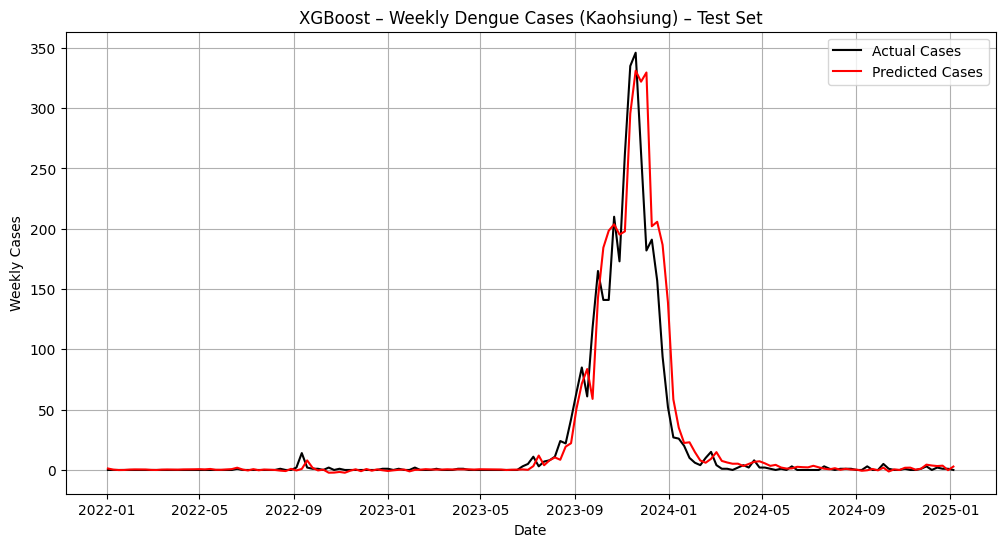

In [14]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual Cases", color="black")
plt.plot(test.index, y_pred, label="Predicted Cases", color="red")
plt.title("XGBoost – Weekly Dengue Cases (Kaohsiung) – Test Set")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()


## Feature IMportance

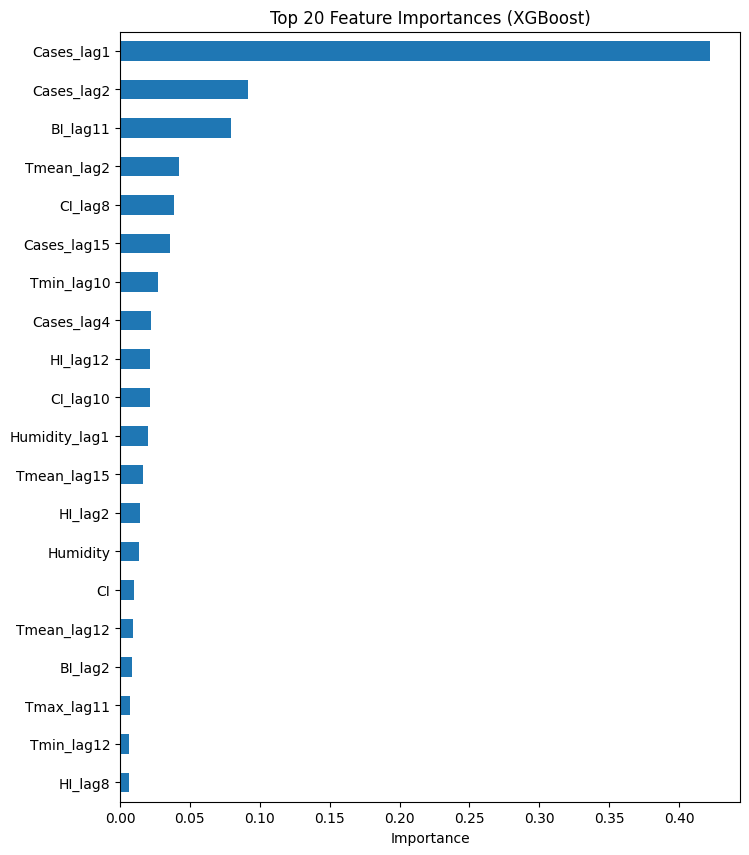

In [15]:
importances = xgb_model.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,10))
fi.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()


## Hyperparameter tuning

In [16]:
train = df_lagged.loc[df_lagged.index < "2022-01-01"].copy()
test  = df_lagged.loc[df_lagged.index >= "2022-01-01"].copy()


In [17]:
# Train/test split (you already have this)
train = df_lagged.loc[df_lagged.index < "2022-01-01"].copy()
test  = df_lagged.loc[df_lagged.index >= "2022-01-01"].copy()

# Further split train into train_inner and val by date
val_start = "2018-01-01"   # you can adjust this
train_inner = train.loc[train.index < val_start].copy()
val_df      = train.loc[train.index >= val_start].copy()

print("Train inner:", train_inner.shape)
print("Validation :", val_df.shape)
print("Test       :", test.shape)


Train inner: (403, 84)
Validation : (208, 84)
Test       : (158, 84)


In [18]:
# Target
y_train_inner = train_inner["Cases"].values
y_val         = val_df["Cases"].values
y_test        = test["Cases"].values

# Features
feature_cols = [c for c in df_lagged.columns if c != "Cases"]

X_train_inner = train_inner[feature_cols].values
X_val         = val_df[feature_cols].values
X_test        = test[feature_cols].values


In [19]:
param_grid = {
    "max_depth":        [2, 3, 4, 8],
    "learning_rate":    [0.01, 0.05, 0.07],
    "n_estimators":     [500, 600, 800],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],  # (recommended to include)
    "random_state":     [42]              # fixed parameter must still be a list
}


In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from itertools import product

results = []

for max_depth, learning_rate, n_estimators, subsample, colsample_bytree in product(
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['n_estimators'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
):
    print(f"\nTrying: max_depth={max_depth}, lr={learning_rate}, "
          f"n_estimators={n_estimators}, subsample={subsample}, "
          f"colsample_bytree={colsample_bytree}")

    model = XGBRegressor(
        objective="reg:squarederror",
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    # 👇 no eval_metric, no verbose
    model.fit(X_train_inner, y_train_inner)

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"  -> val RMSE: {rmse_val:.4f}")

    results.append({
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "val_rmse": rmse_val
    })

results_df = pd.DataFrame(results).sort_values("val_rmse")
results_df.head()



Trying: max_depth=2, lr=0.01, n_estimators=500, subsample=0.8, colsample_bytree=0.8
  -> val RMSE: 4.8183

Trying: max_depth=2, lr=0.01, n_estimators=500, subsample=0.8, colsample_bytree=1.0
  -> val RMSE: 4.9782

Trying: max_depth=2, lr=0.01, n_estimators=500, subsample=1.0, colsample_bytree=0.8
  -> val RMSE: 5.0053

Trying: max_depth=2, lr=0.01, n_estimators=500, subsample=1.0, colsample_bytree=1.0
  -> val RMSE: 4.9014

Trying: max_depth=2, lr=0.01, n_estimators=600, subsample=0.8, colsample_bytree=0.8
  -> val RMSE: 3.7076

Trying: max_depth=2, lr=0.01, n_estimators=600, subsample=0.8, colsample_bytree=1.0
  -> val RMSE: 3.8712

Trying: max_depth=2, lr=0.01, n_estimators=600, subsample=1.0, colsample_bytree=0.8
  -> val RMSE: 3.6838

Trying: max_depth=2, lr=0.01, n_estimators=600, subsample=1.0, colsample_bytree=1.0
  -> val RMSE: 3.8071

Trying: max_depth=2, lr=0.01, n_estimators=800, subsample=0.8, colsample_bytree=0.8
  -> val RMSE: 3.0986

Trying: max_depth=2, lr=0.01, n_esti

,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,val_rmse
135,8,0.07,500,1.0,1.0,2.350018
143,8,0.07,800,1.0,1.0,2.350018
139,8,0.07,600,1.0,1.0,2.350018
77,4,0.01,600,0.8,1.0,2.382261
123,8,0.05,500,1.0,1.0,2.417994


In [21]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_rmse")
results_df.head()


,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,val_rmse
135,8,0.07,500,1.0,1.0,2.350018
143,8,0.07,800,1.0,1.0,2.350018
139,8,0.07,600,1.0,1.0,2.350018
77,4,0.01,600,0.8,1.0,2.382261
123,8,0.05,500,1.0,1.0,2.417994


In [22]:
# Get the best row (lowest val_rmse)
best_params = results_df.iloc[0].to_dict()
print("Best params:", best_params)


Best params: {'max_depth': 8.0, 'learning_rate': 0.07, 'n_estimators': 500.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'val_rmse': 2.350018395335988}


In [23]:
# Combine train_inner + val_df
full_train = pd.concat([train_inner, val_df]).sort_index()

X_full_train = full_train[feature_cols].values
y_full_train = full_train["Cases"].values

final_model = XGBRegressor(
    objective="reg:squarederror",
    max_depth=int(best_params["max_depth"]),
    learning_rate=float(best_params["learning_rate"]),
    n_estimators=int(best_params["n_estimators"]),
    subsample=float(best_params["subsample"]),
    colsample_bytree=float(best_params["colsample_bytree"]),
    random_state=42
)

final_model.fit(X_full_train, y_full_train)



,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Evaluation Metrics

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_pred = final_model.predict(X_test)

mse  = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)

print("📊 Tuned XGBoost performance on TEST:")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")


📊 Tuned XGBoost performance on TEST:
MSE  : 651.7658
RMSE : 25.5297
MAE  : 8.1472
R²   : 0.8221


## Visualization

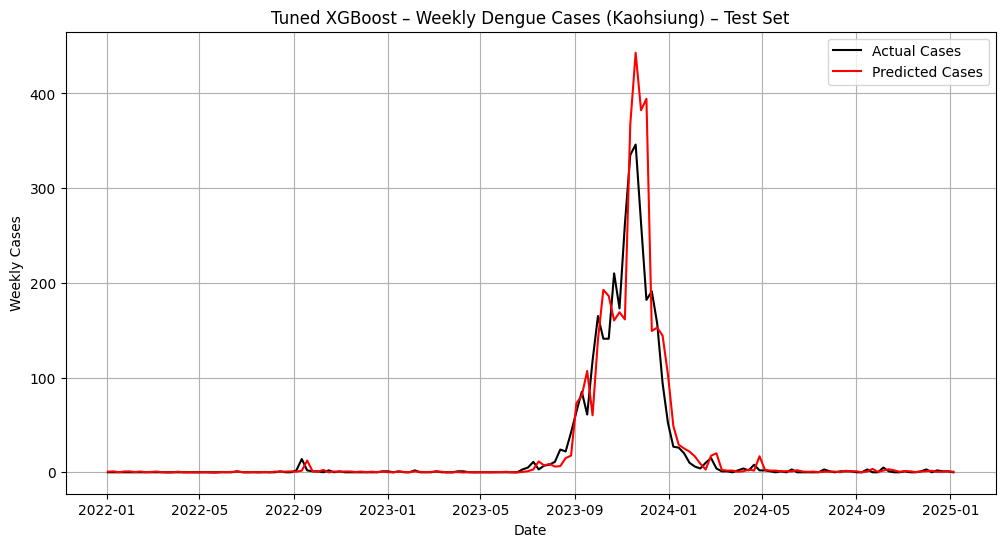

In [25]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test,      label="Actual Cases",    color="black")
plt.plot(test.index, y_test_pred, label="Predicted Cases", color="red")
plt.title("Tuned XGBoost – Weekly Dengue Cases (Kaohsiung) – Test Set")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()


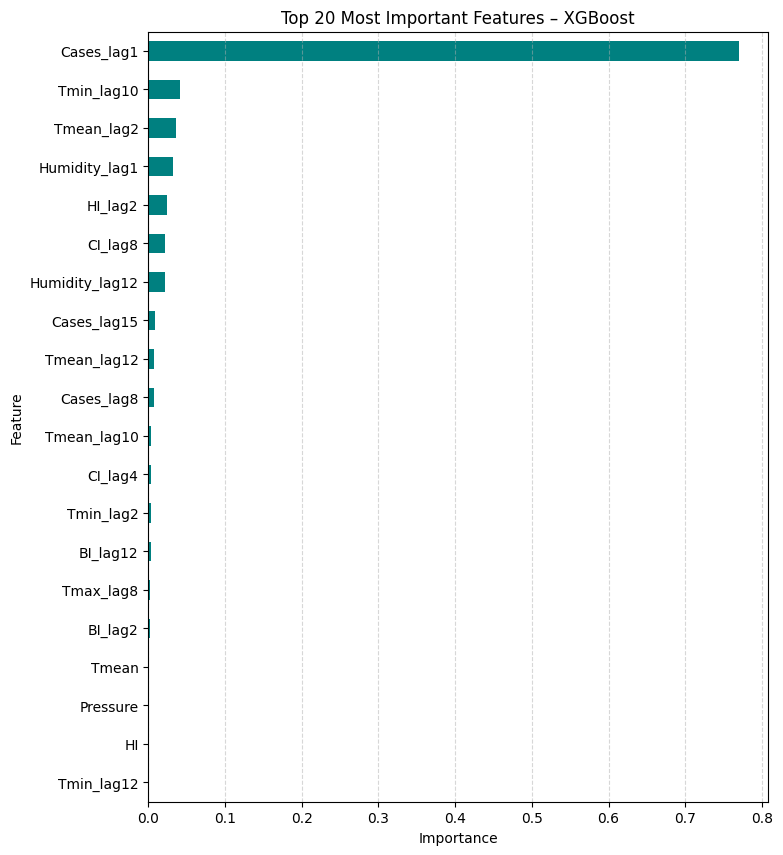

In [27]:
plt.figure(figsize=(8,10))
fi.head(20).plot(kind="barh", color="teal")
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features – XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


In [28]:
# %% [markdown]
# ## Save artifacts for Streamlit

import os, json

os.makedirs("../artifacts", exist_ok=True)

city_code = "ks"          # Kaohsiung
model_name = "xg"         # XGBoost

# 1) Save test predictions from the **tuned** model
pred_df = pd.DataFrame({
    "Date": test.index,        # weekly index
    "y_test": y_test,
    "y_pred": y_test_pred      # <--- tuned predictions
})
pred_path = f"../artifacts/{model_name}_{city_code}_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("Saved predictions to", pred_path)

# 2) Save feature importance (from tuned model)
fi_df = fi.to_frame(name="importance")   # fi already built from final_model
fi_path = f"../artifacts/{model_name}_{city_code}_feature_importance.csv"
fi_df.to_csv(fi_path)
print("Saved feature importance to", fi_path)

# 3) Save metrics (tuned)
metrics = {
    "MSE": float(mse),
    "RMSE": float(rmse),
    "MAE": float(mae),
    "R2": float(r2),
}
metrics_path = f"../artifacts/{model_name}_{city_code}_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to", metrics_path)

# 4) (Optional) save best hyperparameters
best_params_path = f"../artifacts/{model_name}_{city_code}_best_params.json"
with open(best_params_path, "w") as f:
    json.dump(best_params, f, indent=2)
print("Saved best params to", best_params_path)


Saved predictions to ../artifacts/xg_ks_predictions.csv
Saved feature importance to ../artifacts/xg_ks_feature_importance.csv
Saved metrics to ../artifacts/xg_ks_metrics.json
Saved best params to ../artifacts/xg_ks_best_params.json
